# Bank Customer Churn Prediction


## **Problem Statement**



Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

We will build a neural network-based binary classifier to predict whether the bank customer will churn or not in the next 6 months.

## **Data Description**

The bank's dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

- RowNumber: Unique index
- CustomerId: Unique ID which is assigned to each customer
- Surname: Last name of the customer 
- CreditScore: It defines the credit history of the customer.  
- Geography: A customer’s location    
- Gender: It defines the Gender of the customer   
- Age: Age of the customer     
- Tenure: Number of years for which the customer has been with the bank
- NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
- Balance: Account balance
- HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
- EstimatedSalary: Estimated salary 
- isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
- Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values: 0=No (Customer did not leave the bank )
1=Yes ( Customer left the bank ).


## **Assumptions**

We are going to make the following assumptions.

1. The sample data is equally representative of all customers of the bank, that is, it collects all possible variations of customer's characteristics.
2. The sample data is not exposed to data bias, that is it was not sampled to direct the predictions in one way or another.
3. The sample data is equally proportional among features to the whole data of the bank (that is, if tenure = 10 in the whole data is 5%, then in the sample data, the tenure represents 5%).
4. The data is until the end of the year. That means, that Tenure=0, are customers from Jan1 to Dec31.



##**Initial Definitions**

In [1]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [2]:
#import libraries

#ignoring warnings
import warnings
warnings.filterwarnings("ignore")
#importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import tensorflow as tf
import keras
import random
from random import shuffle
random.seed(1)
np.random.seed(1) 
tf.random.set_seed(1)

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score 
from sklearn.metrics import recall_score, f1_score, precision_recall_curve 
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score 
from sklearn.metrics import mean_absolute_error,auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, InputLayer
from keras import optimizers, callbacks
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, RMSprop, SGD

import warnings
warnings.filterwarnings("ignore")


<IPython.core.display.Javascript object>

In [3]:
#allow access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

<IPython.core.display.Javascript object>

Mounted at /content/gdrive


In [4]:
#read csv file and load into a panda dataframe
data = pd.read_csv('/content/gdrive/MyDrive/UT-ML/Projects/Project7/bank.csv')

<IPython.core.display.Javascript object>

# **Functions**

In [5]:
#Useful functions for this notebook

#Function to show %
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 4))
    else:
        plt.figure(figsize=(n + 2, 4))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#function to create histograms and boxplots at once
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100

#function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf


##  Function to calculate r2_score and RMSE on train and test data
def get_model_score(model, flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_r2=metrics.r2_score(y_train,pred_train)
    test_r2=metrics.r2_score(y_test,pred_test)
    train_rmse=np.sqrt(metrics.mean_squared_error(y_train,pred_train))
    test_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_test))
    
    #Adding all scores in the list
    score_list.extend((train_r2,test_r2,train_rmse,test_rmse))
    
    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag==True: 
        print("R-sqaure on training set : ",metrics.r2_score(y_train,pred_train))
        print("R-square on test set : ",metrics.r2_score(y_test,pred_test))
        print("RMSE on training set : ",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
        print("RMSE on test set : ",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))
    
    # returning the list with train and test scores
    return score_list

def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=labels, fmt="",annot_kws={"size":20})
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (6,6))
    sns.heatmap(df_cm, annot=labels,fmt='',annot_kws={"size":20})
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

'''
def metrics_score(actual, predicted):
  print(classification_report(actual, predicted));
  cm = confusion_matrix(actual, predicted);
  plt.figure(figsize=(8,5));
  sns.heatmap(cm, annot=True, fmt='.2f')
  plt.ylabel('Actual'); plt.xlabel('Predicted');
  plt.show()
'''

##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=labels, fmt="",annot_kws={"size":20})
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

# **Dataset Overview, Dataset Quick Analysis and Pre-Processing**

### **Data Overview - Quick Analysis**

In [6]:
#Visualize the shape of the dataframe
print("The dataset contains %d"%data.shape[0] + " rows.")
print("The dataset contains %d"%data.shape[1] + " columns.")

<IPython.core.display.Javascript object>

The dataset contains 10000 rows.
The dataset contains 14 columns.


In [7]:
#Visualize dataframe basic information
data.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are 3 Categorical features (Surname, Geography, and Gender) and 11 numerical features. We anticipate that we will drop 'Surname', 'RowNumber', and 'CustomerId'. 

Notice that info() reports no null values in the dataset.

In [8]:
#visualize the head of the dataframe
data.head()

<IPython.core.display.Javascript object>

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
#visualize the tail of the dataframe
data.tail()

<IPython.core.display.Javascript object>

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


From observing the head and tail we anticipate that Age, Balance, Tenure, CreditScore, and EstimatedSalary will probably have to be normalized so the large values don't overwhelmingly overwhelm the model. We also anticipate that Geography and Gender will have to be label encoded to be of use in our model.

In [10]:
#some statistics about the dataFrame
data.describe().T

<IPython.core.display.Javascript object>

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


**CreditScore.** There maximum CreditScore is 850 and the minimum is 350. The average is 651 and the standard deviation is 97, accounting for a large difference between quartiles. Q1 is 584 and Q3 is 718. The median is 65. 

**Age.** The oldest customer is 92 and the youngest is 18. The average is 39 and the standard deviation is 10.49. Q1 is 32 and Q3 is 44. The median is 37. This points that the majority of customers at the bank are 44 or younger.

**Balance.** The largest balance is 251K and the smallest balance is 0. The average is 76K and the standard deviation is 62K. Q1 is 0 and Q3 is 128K. The median is 97K. 

**EstimatedSalary.** The largest est. salary is 200K and the smallest is 58K. The average is 100K and the standard deviation is 57K. Q1 is 51K and Q3 is 149K. The median is 100K.

The statistics of all the other features are not relevant. 

###**Analyzing Null or Missing Values**

In [11]:
#Checking missing values
data.isna().sum()

<IPython.core.display.Javascript object>

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There are no null values in agreement with info().

###**Checking Duplicated Values**

In [12]:
#Duplicated entries (exact entries or 2 or more rows are exactly the same)
data.duplicated().sum()

<IPython.core.display.Javascript object>

0

There are no duplicated entries.

In [13]:
#Duplicated Customers (duplicated customer key)?
data['CustomerId'].duplicated().sum()

<IPython.core.display.Javascript object>

0

There is only one entry per customer.

### **Dropping No Contribution Features**

In [14]:
#copy original dataframe to a 'work' dataframe
dataw_df = data.copy()

<IPython.core.display.Javascript object>

Previously we had anticipated that some features would be dropped because they do not contribute anything to the analysis and model. 

The features that do not contribute to the model are:

- RowNumber: index of row
- CustomerId: an internal use number
- Surname: name of customer. 

Note that the Surname should have never been included in the dataset. This is a major liability because it may violate state/federal privacy laws and violate the customer's  bank secret.

In [15]:
#Drop columns that do not contribute to data analysis
coltodrop = ['RowNumber','CustomerId','Surname']
dataw_df.drop(coltodrop, axis=1,inplace=True)

<IPython.core.display.Javascript object>

In [16]:
# Making a list of all variables
cat_col = [
    "CreditScore",
    "Geography",
    "Gender",
    "Age",   
    "Tenure",
    "Balance",
    "NumOfProducts",
    "HasCrCard",
    "IsActiveMember",
    "EstimatedSalary",
    "Exited"
]
i=0
#features types, counts for categorical columns
for column in cat_col:
    print(cat_col[i])
    print("-"*55)
    print(dataw_df[column].value_counts())
    print("\n")
    i+=1

<IPython.core.display.Javascript object>

CreditScore
-------------------------------------------------------
850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: CreditScore, Length: 460, dtype: int64


Geography
-------------------------------------------------------
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64


Gender
-------------------------------------------------------
Male      5457
Female    4543
Name: Gender, dtype: int64


Age
-------------------------------------------------------
37    478
38    477
35    474
36    456
34    447
     ... 
92      2
82      1
88      1
85      1
83      1
Name: Age, Length: 70, dtype: int64


Tenure
-------------------------------------------------------
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64


Balance
-------------------------------------------------------
0.00       

# **Univariate Analysis**

- CreditScore: It defines the credit history of the customer.
- Geography: A customer’s location
- Gender: It defines the Gender of the customer
- Age: Age of the customer
- Tenure: Number of years for which the customer has been with the bank
- NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
- Balance: Account balance
- HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
- EstimatedSalary: Estimated salary
- isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
-Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values: 0=No (Customer did not leave the bank ) 1=Yes ( Customer left the bank ).

In [17]:
#Declare and Initialize variables for figure numbering
figNo=1
j=0

#Convert Dataframe to Yes/No and Categorical for visualization Purposes
datav_df = dataw_df.copy()


datav_df = datav_df.replace({'Exited':{0:'No', 1:'Yes'},'HasCrCard':{0:'No',1:'Yes'},
                             'IsActiveMember':{0:'No',1:'Yes'}})

<IPython.core.display.Javascript object>

###**CreditScore**

CreditScore (numerical):  It defines the credit score of the customer.

<IPython.core.display.Javascript object>

Fig 1 - CreditScore


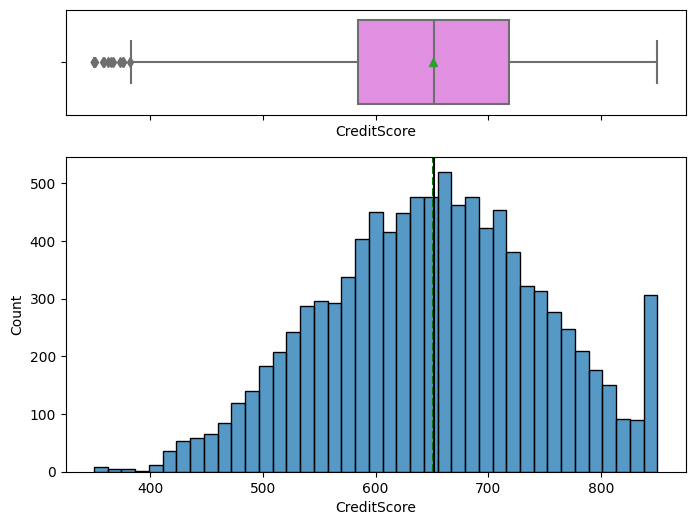

In [18]:
#visualize the distribution of CreditScore

Title_cat = cat_col[j]
print("Fig "+ str(figNo)+" - "+ Title_cat)
figNo+=1

#Plot histogram of feature CreditScore
histogram_boxplot(datav_df, "CreditScore", figsize=(8,6), kde=False, bins=None)

CreditScore distribution is skewed to the left with outliers below 400. From the distribution we can see that the median is about 660 and the mean is about the same than the median. 

We cannot determine the mode from this plot. In fact, this plot is deceiving. It may lead us to believe that a CreditScore around 670 is the mode. However, the bars represents bins, not unique values.  

Notice that there is a high number of customers with a high credit score above 840. 

The outlier values below 400 are valid because the bank may have customers that have a very low CreditScore. Also the highest CreditScores are also valid because there are always customers with very high scores in the bank industry.

We will not drop these outliers as they represent valid data.

In [19]:
#Recalculate some statistics
cs_mode = datav_df['CreditScore'].mode()[0]
cs_mean = datav_df['CreditScore'].mean()
cs_max = datav_df['CreditScore'].max()
cs_min = datav_df['CreditScore'].min()
cs_std = datav_df['CreditScore'].std()
cs_med = datav_df['CreditScore'].median()

cssdf = {'min': [cs_min], 'mean': [cs_mean], 'max': [cs_max], 'mode': [cs_mode],
          'stdev': [cs_std], 'median': [cs_med]}

csStat = pd.DataFrame(cssdf)
csStat

<IPython.core.display.Javascript object>

,min,mean,max,mode,stdev,median
0,350,650.5288,850,850,96.653299,652.0


We checked from our calculations that the mode is 850, the mean is 651, the max is 850, and the min is 350. The standard deviation is 97 and the median is 652. 

Notice that the mode is equal to the maximum CreditScore.

We will keep all outliers as they represent valid data.

In [20]:
#visualize repetitions of CreditScore
datav_df['CreditScore'].value_counts(ascending=False)

<IPython.core.display.Javascript object>

850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: CreditScore, Length: 460, dtype: int64

We can see that 850, which also happens to be the maximum CreditScore, is overwhelmingly the most common CreditScore. Next is 678, 655, 705, and 667. All are good scores. So we can infer that the most common CreditScores are high scores. As we can see that the distribution plot is skewed to the left, the bank customers' credit score trends to be good.

In [21]:
figNo=2
j=0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fig 2 - CreditScore (15 most common)


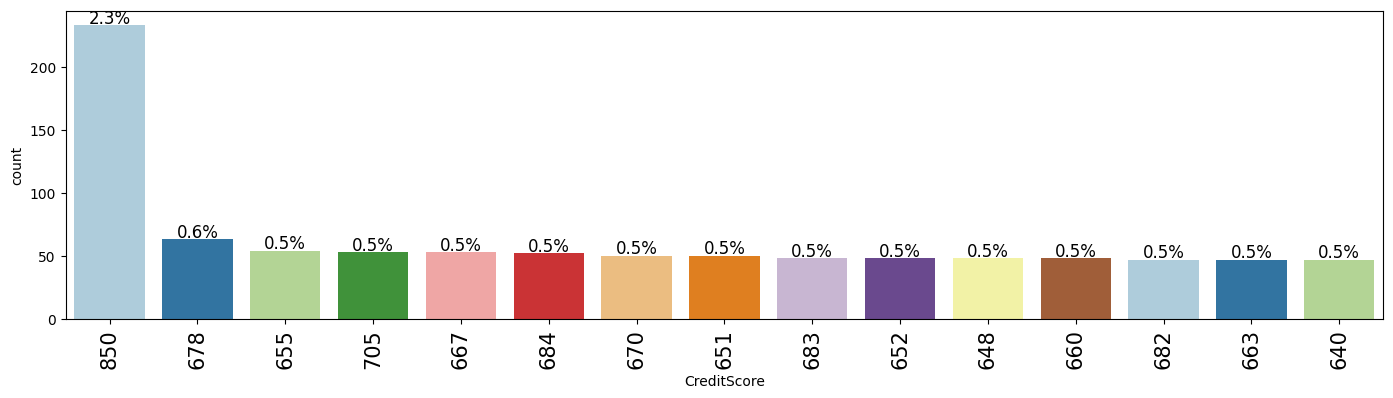

In [22]:
#visualize most common credit scores

Title_cat = cat_col[j]
print("Fig "+ str(figNo)+" - "+ Title_cat + " (15 most common)")
figNo+=1
j+=1

#Plot barplot of feature CreditScore
labeled_barplot(datav_df, "CreditScore", perc=True, n=15)

2.3% of customers have a CreditScore of 850. We can see that a high credit score is common at the bank.


###**Geography**

A customer’s location.

<IPython.core.display.Javascript object>

Fig 3 - Geography


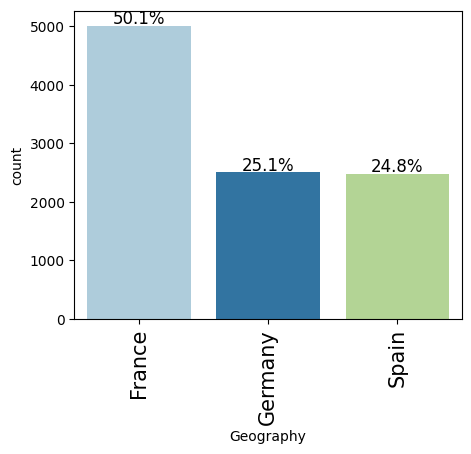

In [23]:
#visualize customer's location distribution

Title_cat = cat_col[j]
print("Fig "+ str(figNo)+" - "+ Title_cat)
figNo+=1
j+=1

#Plot barplot of feature Geography distribution
labeled_barplot(datav_df, "Geography", perc=True, n=None)

50% of customers are in France. 25% are in Germany and 25% are in Spain.

### **Gender**

Feature that specifies if a customer is male or female. 

<IPython.core.display.Javascript object>

Fig 4 - Gender


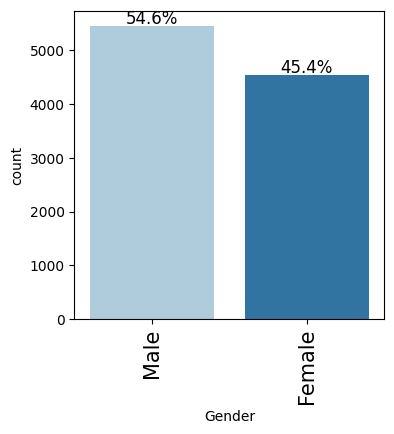

In [24]:
#visualize customer's gender distribution

Title_cat = cat_col[j]
print("Fig "+ str(figNo)+" - "+ Title_cat)
figNo+=1
j+=1

#Plot barplot of feature Gender distribution
labeled_barplot(datav_df, "Gender", perc=True, n=None)

###**Age**

Customer age in years.

<IPython.core.display.Javascript object>

Fig 5 - Age


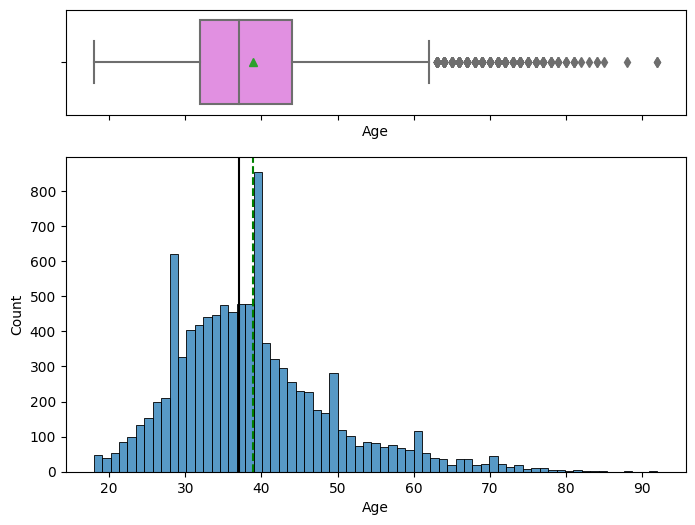

In [25]:
#Visualize the distribution of Age
Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1

#Plot histogram of feature Age
histogram_boxplot(datav_df, "Age", figsize=(8, 6), kde=False, bins=None)

Age distribution is skewed to the right with outliers beyond 60. From the distribution we can see that the median is about 37 and the mean is about 39. 

We can also observe that the mode is about 37-38 (the second most common age is 26-28.

The distribution shows that the bank's population is young.

The outlier values are valid because the bank may have customers that belong to the baby boomer generation and older. The data of these customers may be important, so we will not drop these outliers.

In [26]:
#Recalculate some statistics
age_mode = dataw_df['Age'].mode()[0]
age_mean = dataw_df['Age'].mean()
age_max = dataw_df['Age'].max()
age_min = dataw_df['Age'].min()
age_std = dataw_df['Age'].std()
age_med = dataw_df['Age'].median()

agesdf = {'min': [age_min], 'mean': [age_mean], 'max': [age_max], 'mode': [age_mode],
          'stdev': [age_std], 'median': [age_med]}

ageStat = pd.DataFrame(agesdf)
ageStat

<IPython.core.display.Javascript object>

,min,mean,max,mode,stdev,median
0,18,38.9218,92,37,10.487806,37.0


We verified from our calculations that the mode is 37, the mean is 39, the max age is 92, and the min age is 18. 

We will keep all outliers as they represent valid data.

In [27]:
figNo=6
j=3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fig 6 - Age (15 most common)


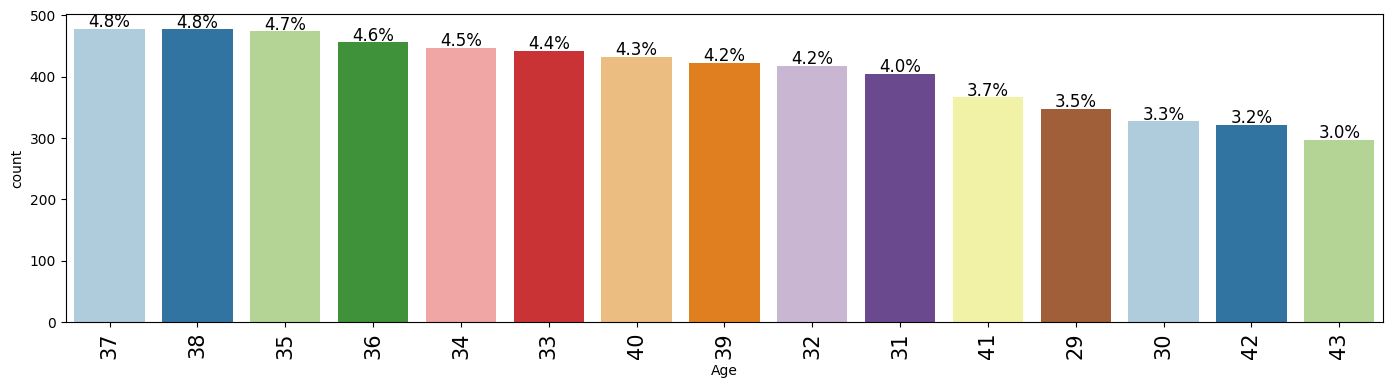

In [28]:
#visualize most common Ages Distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title +" (15 most common)")
figNo+=1
j+=1

#Plot barplot of feature Age
labeled_barplot(datav_df, "Age", perc=True, n=15)

The most common age is 37 (mode). The most common ages are in the range from 30 to 41. We can deduct that most customers are relatively young.

###**Tenure**

Tenure is the amount of years the customer has been with the bank.

In [29]:
figNo=7
j=4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fig 7 - Tenure


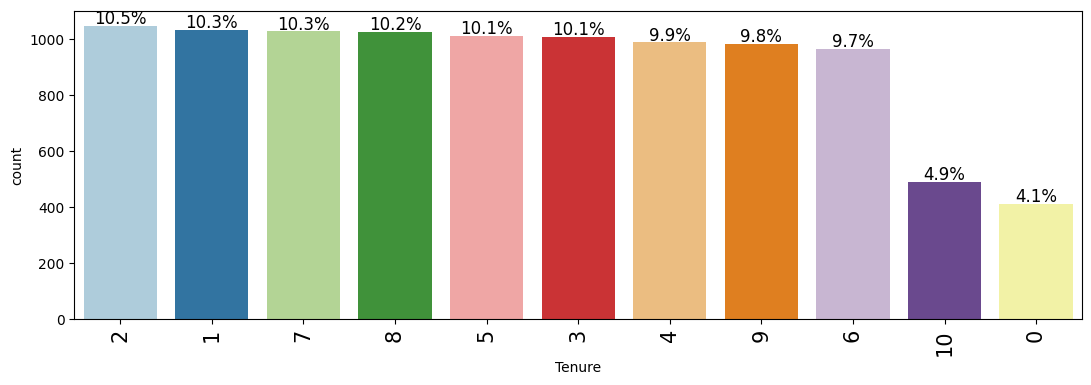

In [30]:
#visualize most common Ages Distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1

#Plot barplot of feature Tenure
labeled_barplot(datav_df, "Tenure", perc=True, n=None)

Notice that between 1 to 9 years, the distribution is very similar, between 9.7% to 10.5% of the total number of customers. Customers that have a tenure of 10 years are only 4.9% and new customers (0 years) are only 4.1%.

We are wondering why customers with tenure 10 years are only 4.9%, less than 50% than customers with tenure 1 year.  Is this because the bank opened 10 years ago and tenure=10 are the first customers?

Also we can't help ask why the number of new customers (tenure=0) is the lowest with only 4.1% of all customers. This has to be analyzed in detail later in our study but this may be an indication that either the market is saturated or the bank has not grown in this year.


In [31]:
figNo=8
j=4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fig 8 - Tenure


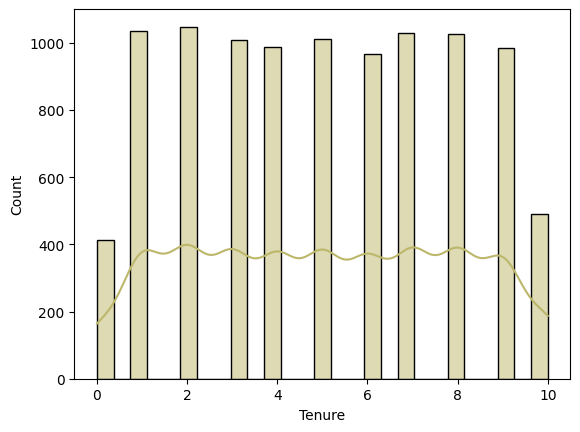

In [32]:
#visualize the Tenure distribution with Kernel density estimation 

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#plot a histogram to visualize the number of customer per tenure year
sns.histplot(dataw_df, x= "Tenure", stat="count",color="DarkKhaki", kde=True)
plt.show()

Certainly customers with tenure 10 are around 500, and new customers are barely more than 400. Considering our Assumptions (at the beginning of this study), we can deduct that the growth of customer acquisition has fallen significantly from the previous year new customers have fallen significantly by 62% in comparison to the previous year, and 64% in comparison to 2 years ago. This isn't very good news for the bank.

Again, considering the Assumptions made earlier, we can conclude that either the bank had a major customer growth 10 years ago of 62% or that was actually the first year of the bank's operations.

Also, after the first year, the bank never experience such a year-to-year growth gain again.

In [33]:
#Recalculate some statistics
ten_mode = dataw_df['Tenure'].mode()[0]
ten_mean = dataw_df['Tenure'].mean()
ten_max = dataw_df['Tenure'].max()
ten_min = dataw_df['Tenure'].min()
ten_std = dataw_df['Tenure'].std()
ten_med = dataw_df['Tenure'].median()

tensdf = {'min': [ten_min], 'mean': [ten_mean], 'max': [ten_max], 'mode': [ten_mode],
          'stdev': [ten_std], 'median': [ten_med]}

tenStat = pd.DataFrame(tensdf)
tenStat

<IPython.core.display.Javascript object>

,min,mean,max,mode,stdev,median
0,0,5.0128,10,2,2.892174,5.0


The only meaningful statistics is the mode. Customers with 2 years tenure are the largest group.


###**Balance**

How much money the customer has in the bank.

<IPython.core.display.Javascript object>

Fig 9 - Balance


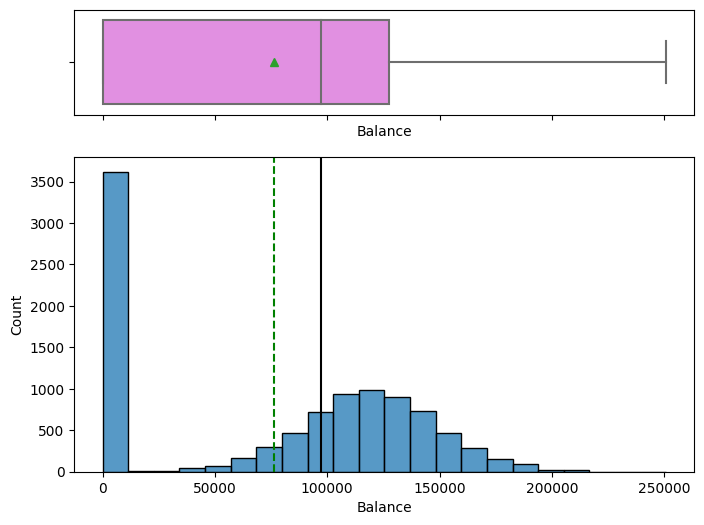

In [34]:
#visualize the Balance distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#plot a histogram for Balance distribution
histogram_boxplot(datav_df, "Balance", figsize=(8,6), kde=False, bins=None)

Notice that over 3500 customers have 0 balance (or nearly zero balance). We have seen earlier that actually 3,617 customers have zero balance. This may indicate non active customers but also customers that do not have bank accounts with the bank (only credit cards).

In [35]:
#Recalculate some statistics
bal_mode = datav_df['Balance'].mode()[0]
bal_mean = datav_df['Balance'].mean()
bal_max = datav_df['Balance'].max()
bal_min = datav_df['Balance'].min()
bal_std = datav_df['Balance'].std()
bal_med = datav_df['Balance'].median()

balsdf = {'min': [bal_min], 'mean': [bal_mean], 'max': [bal_max], 'mode': [bal_mode],
          'stdev': [bal_std], 'median': [bal_med]}

balStat = pd.DataFrame(balsdf)
balStat

<IPython.core.display.Javascript object>

,min,mean,max,mode,stdev,median
0,0.0,76485.889288,250898.09,0.0,62397.405202,97198.54


The above statistics are highly influenced by a the large group of customers with zero balance. However, keep in mind that customers with zero balance represent a valid and useful data. 

However, we can also visualize the data without customers with balance zero and observe the statistics.

In [36]:
#Drop customers that have a zero balance
bal_noZero_df = datav_df.loc[datav_df['Balance']>0]

#Recalculate statistics for balance>0
bal_zero_mode = bal_noZero_df['Balance'].mode()[0]
bal_zero_mean = bal_noZero_df['Balance'].mean()
bal_zero_max = bal_noZero_df['Balance'].max()
bal_zero_min = bal_noZero_df['Balance'].min()
bal_zero_std = bal_noZero_df['Balance'].std()
bal_zero_med = bal_noZero_df['Balance'].median()

bal_zerosdf = {'min': [bal_zero_min], 'mean': [bal_zero_mean], 'max': [bal_zero_max], 'mode': [bal_zero_mode],
          'stdev': [bal_zero_std], 'median': [bal_zero_med]}

bal_zeroStat = pd.DataFrame(bal_zerosdf)
bal_zeroStat

<IPython.core.display.Javascript object>

,min,mean,max,mode,stdev,median
0,3768.69,119827.493793,250898.09,105473.74,30095.056462,119839.69


Notice that among customers with Balance>0, the minimum balance is \$3.8K, the maximum balance is \$251K, the average balance is \$120K and the median is \$120K. The standard deviation is \$30k. The most common customer has around \$105K.

So among customers with balance>0, the bank's clientele is rather wealthy.

###**NumOfProducts**

The number of Products a customer has purchased through the bank.

<IPython.core.display.Javascript object>

Fig 10 - NumOfProducts


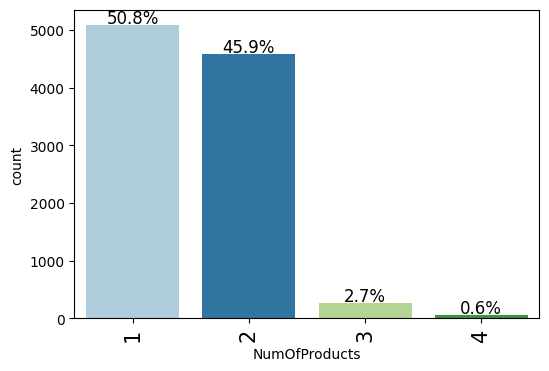

In [37]:
#visualize the NumOfProducts distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#plot a barplot for Number of Products distribution
labeled_barplot(datav_df, "NumOfProducts", perc=True, n=None)

Most customers have 1 product, representing 51% of all customers and 46% have 2 products. Only 3% have 3 products and less than 1% have 4 products. 

More than 96% of customers have up to 2 products with the bank, and less than 4% have 3 or 4 products. Actually almost no customers have 4 products with the bank.

We should analyze later what happens with customers that have 3 and 4 products to see if this could be replicated to bring more 3-4 product customers to the bank. 

###**HasCrCard**

Specifies if the customer has a credit card.

In [38]:
figNo=11
j=7

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fig 11 - HasCrCard


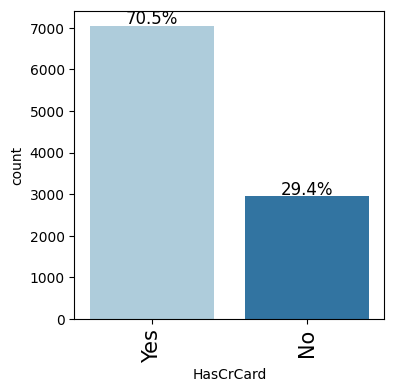

In [39]:
#visualize the HasCard distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#plot a barplot for HasCrCard distribution
labeled_barplot(datav_df, "HasCrCard", perc=True, n=None)

70.5% of customers have a credit card.

###**IsActiveMember**

In [40]:
figNo=12
j=8

<IPython.core.display.Javascript object>

Yes if a customer uses bank products regularly, has regular transactions.

<IPython.core.display.Javascript object>

Fig 12 - IsActiveMember


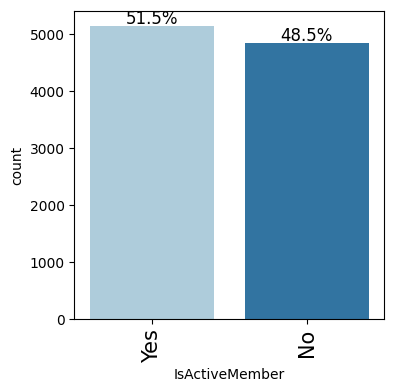

In [41]:
#visualize the IsActiveMember distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#plot a barplot for IsActiveMember distribution
labeled_barplot(datav_df, "IsActiveMember", perc=True, n=None)

52% of customers are active.

###**EstimatedSalary**

The estimated salary of the customers.

In [42]:
figNo=13
j=9

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fig 13 - EstimatedSalary


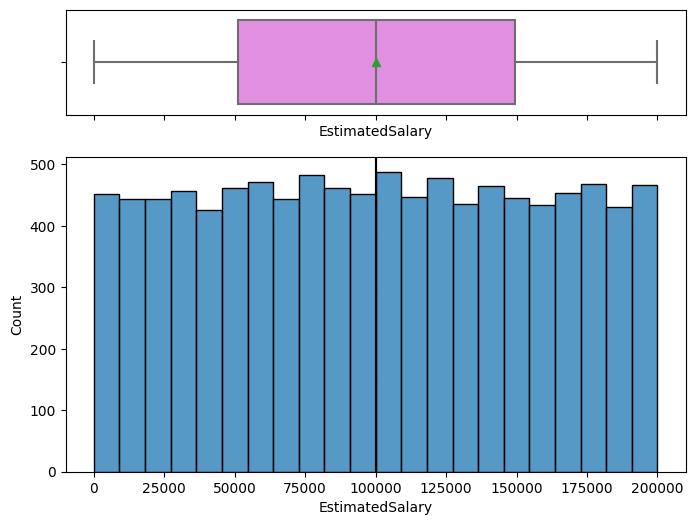

In [43]:
#visualize the EstimatedSalary distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1

#plot a barplot for EstimatedSalary distribution
histogram_boxplot(datav_df, "EstimatedSalary", figsize=(8, 6), kde=False, bins=None)

The distribution of estimated salaries is similar among all customers when grouped in bins. 

In [44]:
#Recalculate some statistics
estSal_mode = datav_df['EstimatedSalary'].mode()[0]
estSal_mean = datav_df['EstimatedSalary'].mean()
estSal_max = datav_df['EstimatedSalary'].max()
estSal_min = datav_df['EstimatedSalary'].min()
estSal_std = datav_df['EstimatedSalary'].std()
estSal_med = datav_df['EstimatedSalary'].median()

estSalsdf = {'min': [estSal_min], 'mean': [estSal_mean], 'max': [estSal_max], 'mode': [estSal_mode],
          'stdev': [estSal_std], 'median': [estSal_med]}

estSalstat = pd.DataFrame(estSalsdf)
estSalstat

<IPython.core.display.Javascript object>

,min,mean,max,mode,stdev,median
0,11.58,100090.239881,199992.48,24924.92,57510.492818,100193.915


The smallest est. salary is \$12K and the largest est. salary is \$200K. The average salary is \$100K and the mode is \$25K. The median is \$100K and the standard deviation is \$57K. 

There is a very large difference between the largest and smallest salary.

There are no outliers in the estimated Salaries data.

In [45]:
figNo=14
j=9

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fig 14 - EstimatedSalary


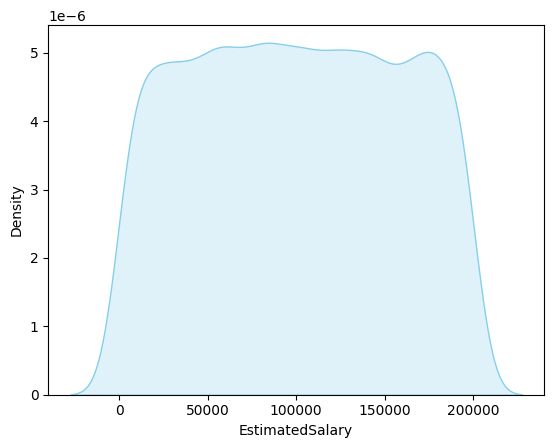

In [46]:
#visualize the EstimatedSalary distribution KDE

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1

sns.kdeplot(data=datav_df, x='EstimatedSalary', color='skyblue', fill= True)
plt.show()

<IPython.core.display.Javascript object>

Fig 15 - EstimatedSalary (15 most common)


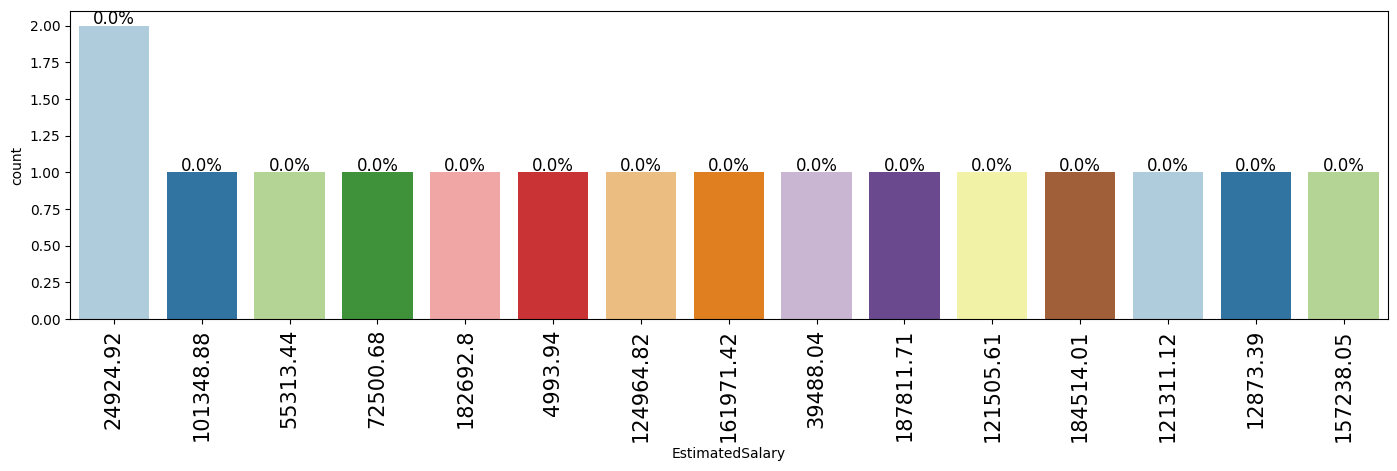

In [47]:
#visualize most common EstSalaries Distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title +" (15 most common)")
figNo+=1
j+=1

#Plot barplot of feature EstimatedSalary
labeled_barplot(datav_df, "EstimatedSalary", perc=True, n=15)

We will revisit EstimatedSalary in the bivariate analysis.

###**Exited**

<IPython.core.display.Javascript object>

Fig 16 - Exited


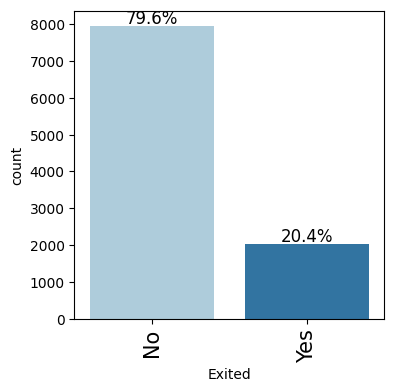

In [48]:
#visualize the Exited distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#Plot barplot of feature Exited
labeled_barplot(datav_df, "Exited", perc=True, n=None)

80% of customers did not churn. 20% of customers churned.

# **BiVariate Analysis**

In [ ]:
#visualize pair plots
#lets use dataw_df because we converted all features to numerical

print("Fig "+str(figNo)+" - "+ "Pairplot")
figNo+=1

sns.pairplot(dataw_df, diag_kind="kde",hue="Exited", height=6, aspect=6, dropna=True)
plt.show()

##**Exited vs Other Features**

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


<Axes: xlabel='Exited', ylabel='CreditScore'>

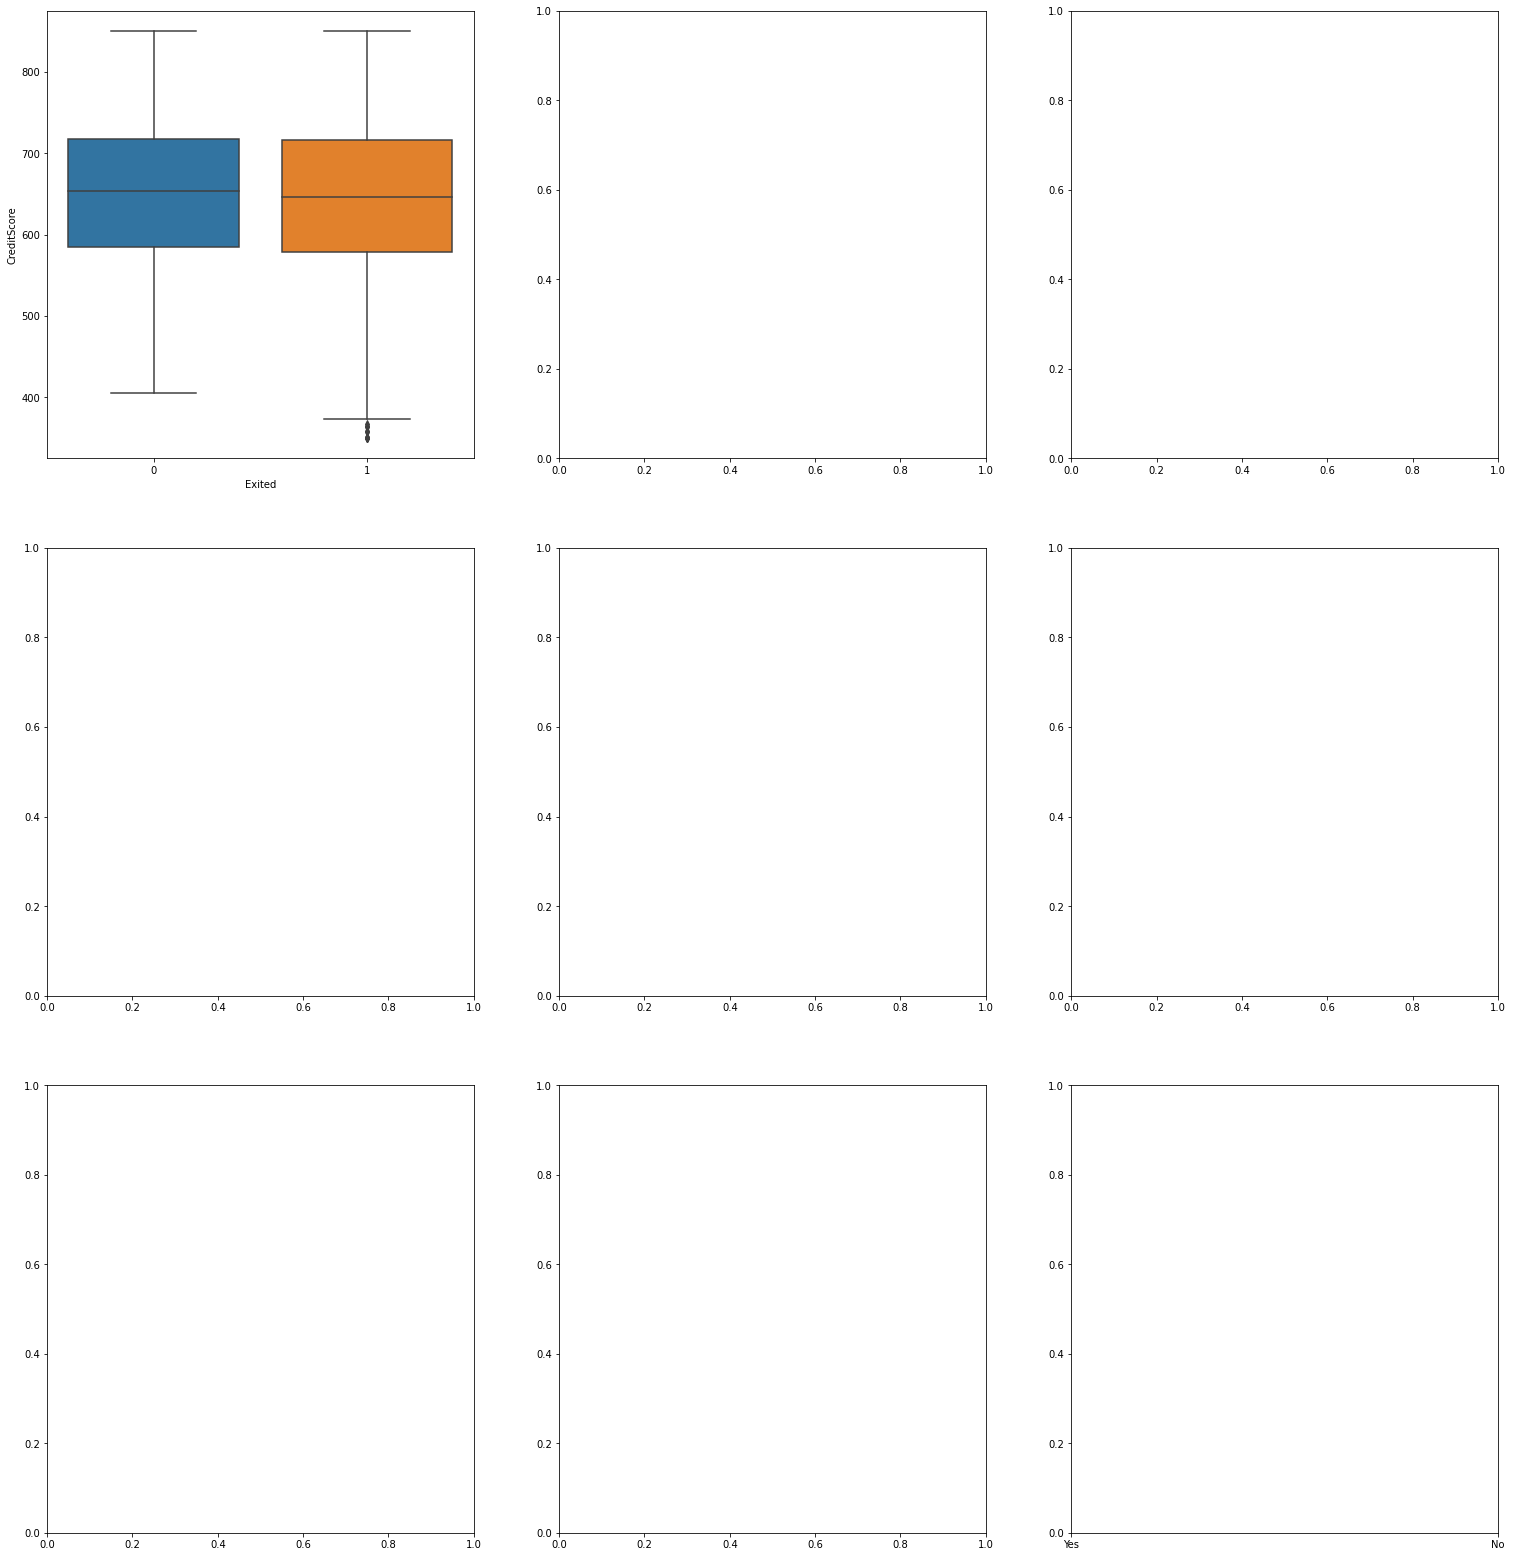

In [ ]:
#sns.set(rc={"figure.figsize": (10, 7)})
fig, axes = plt.subplots(3, 3, figsize=(26,28))

datayn = datadf.copy()

#convert "objects" to categorical to reduce dataframe memory usage
#datayn["Exited"] = datayn["Exited"].astype("category")
datayn.info()
datayn = datadf.replace({'IsActiveMember':{0:'No',1:'Yes'}}, {'HasCrCard':{0:'No',1:'Yes'}} )

#data = [[np.random.rand(100)] for i in range(3)]
#plt.boxplot(data)

plt.xticks([0, 1], ['Yes', 'No'])

sns.boxplot(x="Exited", y = "CreditScore", data=datayn, orient="vertical", ax=axes[0,0])
#sns.boxplot(x="Exited", y = "Age", data=datadf, orient="vertical", ax=axes[0,1])
#sns.histplot(data=datadf, x="Income_Category", hue="Exited", multiple="stack", shrink=.6, ax=axes[0,2])
#sns.histplot(data=datadf, x="Gender", hue="Exited", multiple="stack", shrink=.5, ax=axes[0,1])

#sns.histplot(data=datayn, x="IsActiveMember", hue="Exited", multiple="stack", shrink=.5, ax=axes[0,2])
#sns.histplot(data=datadf, x="Geography", hue="Exited", multiple="stack", shrink=.5, ax=axes[1,0])
#sns.histplot(data=datayn, x="HasCrCard", hue="Exited", multiple="stack", shrink=.5, ax=axes[1,1])

#sns.boxplot(x="Exited", y = "Tenure", data=datadf, orient="vertical", ax=axes[1,0])
#sns.boxplot(x="Exited", y = "NumOfProducts", data=datadf, orient="vertical", ax=axes[1,1])
#sns.histplot(data=datadf, x="", hue="Exited", multiple="stack", shrink=.6, ax=axes[1,2])

#sns.boxplot(x="Exited", y = "HasCrCard", data=datadf, orient="vertical", ax=axes[2,0])
#sns.boxplot(x="Exited", y = "IsActiveMember", data=datadf, orient="vertical", ax=axes[2,1])
#sns.histplot(data=datadf, x="IsActiveMember", hue="Exited", multiple="stack", stat="count", shrink=4, ax=axes[2,2])

#sns.boxplot(x="Exited", y = "", data=data, orient="vertical", ax=axes[3,0])
#sns.boxplot(x="Exited", y = "Total_Relationship_Count", data=data, orient="vertical", ax=axes[3,1])
#sns.histplot(data=datadf, x="Gender", hue="Exited", multiple="stack", shrink=.3, ax=axes[3,2])

#sns.boxplot(x="Exited", y = "Total_Revolving_Bal", data=data, orient="vertical", ax=axes[4,0])
#sns.boxplot(x="Exited", y = "Total_Trans_Ct", data=data, orient="vertical", ax=axes[4,1])
#sns.boxplot(x="Exited", y = "Total_Ct_Chng_Q4_Q1", data=data, orient="vertical", ax=axes[4,2])

#sns.boxplot(x="Exited", y = "Dependent_count", data=data, orient="vertical", ax=axes[5,0])
#sns.boxplot(x="Exited", y = "Avg_Open_To_Buy", data=data, orient="vertical", ax=axes[5,1])
#sns.boxplot(x="Exited", y = "Total_Amt_Chng_Q4_Q1", data=data, orient="vertical", ax=axes[5,2])

<IPython.core.display.Javascript object>

<Axes: xlabel='HasCrCard', ylabel='Count'>

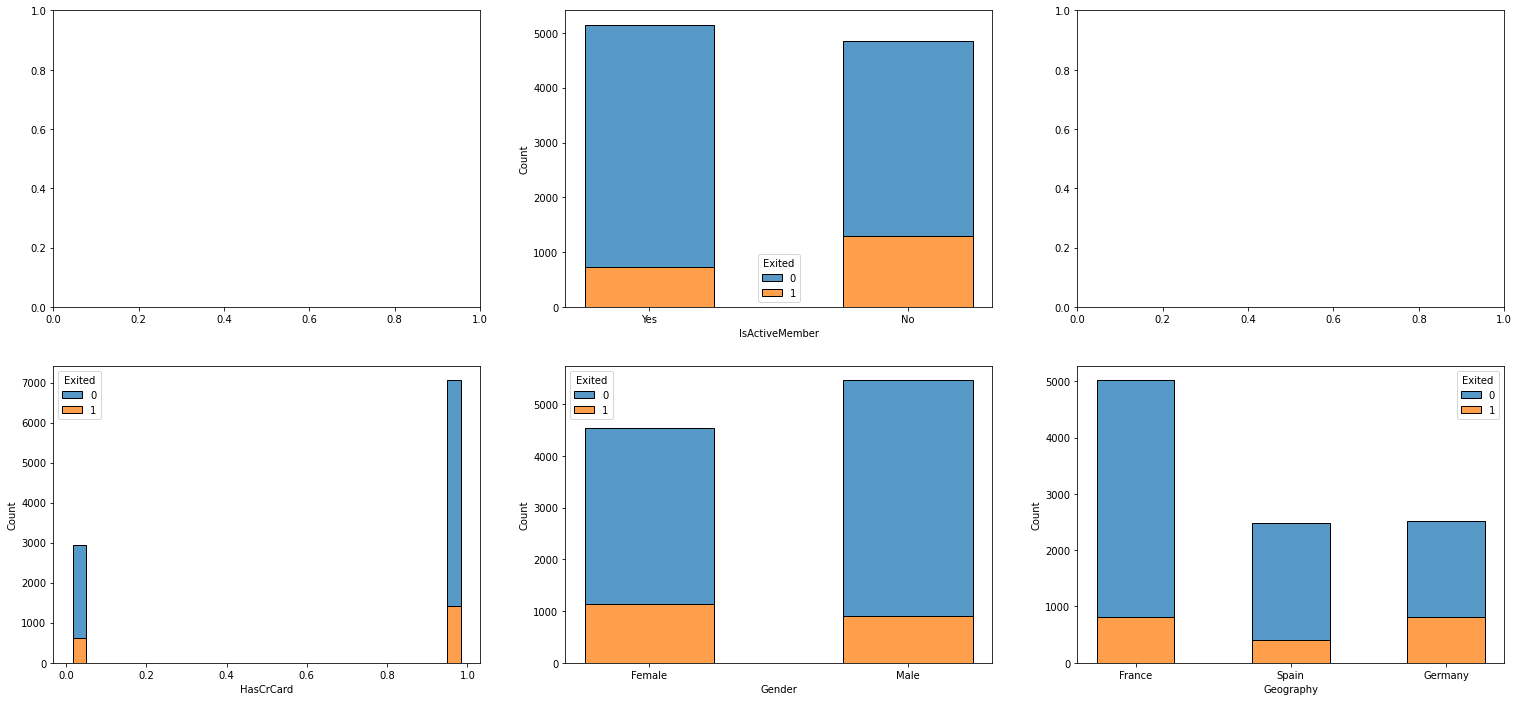

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(26,12))
sns.histplot(data=datadf, x="Gender", hue="Exited", multiple="stack", shrink=.5, ax=axes[1,1])
data_IsActiveMember = datadf.replace({'IsActiveMember':{0:'No',1:'Yes'}},{'HasCrCard':{0:'No',1:'Yes'}})
sns.histplot(data=data_IsActiveMember, x="IsActiveMember", hue="Exited", multiple="stack", shrink=.5, ax=axes[0,1])
sns.histplot(data=datadf, x="Geography", hue="Exited", multiple="stack", shrink=.5, ax=axes[1,2])
sns.histplot(data=data_IsActiveMember, x="HasCrCard", hue="Exited", multiple="stack", shrink=.5, ax=axes[1,0])